# 0.basics


우리는 또 케라스를 쓸겁니다.

거기서 Dense, Conv2D 같은 모듈이 있던 것처럼, RNN 에 대해서도 모듈이 있습니다.

```
import tensorflow as tf
from tf.keras.layers import RNN, LSTM, GRU
```

GRU는 안배웠는데, LSTM보다 더 발전된 형태입니다. 더 발전된건 맞는데 굳이 안써도 되고 써도되고 그렇습니다. 현) 구글 딥마인드에서 일하시는 정준영 박사님이 만드셨고, 우리나라에선 그래서 더 유명하기도 합니다. 우리 수업에서는 기본적인 컨셉은 RNN 계열과 동일하기 때문에 구태여 배우진 않았습니다만, 관심있으시면 혼자 공부해보세요!

# 1.many2one

본 예제는 텐서플로 공식 튜토리얼을 따랐습니다. https://www.tensorflow.org/text/tutorials/text_classification_rnn?hl=ko

IMDB 영화리뷰 데이터 세트에서 좋은지 나쁜지의 BINARY 분류입니다.

먼저 `tensorflow_datasets` 로부터 데이터를 불러오구요

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
# 이건 나중에 visualize 할려고 만든거.
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

데이터를 실제로 `tensorflow_datasets` 에서 load 합니다.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to ~/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

 결과를 프린트해보면
`text: (대충 심한말)` 이었으면
`label: 0` 이 나오네요


In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


데이터 섞기 그리고 배치사이즈를 지정합니다.

BUFFER_SIZE: 그 섞을 크기 지정

BATCH_SIZE: 배치 학습에 넣을 배치 크기 지정

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 인코더

자연어처리하는 경우에는 이 텍스트를 그냥 넣어주지 않고, 단어로 나눈다 음 다시 어떤 숫자로 치환해줍니다. 우리가 one-hot encoding 배웠었죠? 그런식으로 숫자값으로 바꿔야 컴퓨터가 이해할 수 있겠죠.

이런건 `TextVectorization`이 해줍니다. 최대 단어 갯수 `VOCAB_SIZE`를 지정해주고 `encoder`로 저장합니다.

그다음 `encoder.adapt`를 하세요! 자동적으로 자르고 단어로 만들어서 구분지어 넣어줍니다. 

다음은 `adapt()` 메서드가 해주는 것에 대한 공식 설명입니다.



1.  Standardize each example (usually lowercasing + punctuation stripping)

2.  Split each example into substrings (usually words)

3.  Recombine substrings into tokens (usually ngrams)

4. Index tokens (associate a unique int value with each token)

5. Transform each example using this index, either into a vector of ints or a dense float vector.


In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [9]:
# 숫자로도 잘 변환되어있습니다.
print(example)

encoded_example = encoder(example).numpy()
print(encoded_example)
print(encoded_example.shape)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
[ 11  14  34 412 384  18  90  28   1   8  33   1   1  42 487   1 191  24
  85 152  19  11 217 316  28  65 240 214   8 489  54  65  85 112  96  22
   1  11  93 642 743  11  18   7  34 394   1 170   1 408   2  88   1 137
  66 144  51   2   1   1  66 245 

In [10]:
example.dtype

tf.string

In [11]:
print("Original: ", example.numpy())
print("Round-trip: ", " ".join(vocab[encoded_example]))
print()

Original:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Round-trip:  this was an absolutely terrible movie dont be [UNK] in by [UNK] [UNK] or michael [UNK] both are great actors but this must simply be their worst role in history even their great acting could not [UNK] this movies ridiculous storyline this movie is an early [UNK] 

## 간단 RNN classifier



위의 예제까지는 우리가 어떻게 자연어를 처리해서 넣었는지입니다.

이걸 네트워크에 넣기 위해서 우리는 엠베딩이라는 걸 합니다. 이 엠베딩은 dense vector 로 표현하기 위해서 주로 씁니다. 위에서 인코딩 된 예제를 볼때 뒤에 0으로 가득 찬걸 봤죠? 정수를 사용해서 index 로 인코딩하면 그럴수 밖에 없는데, 실수로 구성된 벡터로 표현하면 더 적은 차원의 벡터로 표현할수있습니다. 그래서 엠베딩을 합니다.

근데 엠베딩을 직접 할 수도 있는데요, 직접 어떤 기준에 따라 할수도 있는데, 보통은 그냥 학습 시킵니다. 

그래서 자연어 처리 네트워크 첫 번째는 보통 엠베딩 레이어가 되는 경우가 많아요.

나머지는 RNN 넣고... 등등 하면 되겠죠?

얘는 embedding 역시도 배워야 되기 때문에 shape 이 서로 다른 데이터들이 들어갈 수 밖에 없어요. 데이터를 수정해서 사이즈를 맞춰주면 (padding) 괜찮긴 하지만 tfds에서 주이진 데이터를 건드리고 수정하려면 시간이 많이 걸리니까 그냥 그대로 쓰겠습니다.

근데 그렇게 input shape 을 지정하지 않고 돌릴려면, sequential 방식으로 돌려야합니다. (기억나나요? sequential, functional, subclass API 방식의 keras)

내부적으로 접근이 좀 불편해서 (중간에 hidden layer 값을 가져온다거나하는) 별로 안좋아하지만, 이렇게 처리하기 까다로운 데이터 (인풋 길이가 서로 다른 데이터)를 처리할때는 지정하지 않고 돌릴 수 있는 sequential API 방식이 편합니다.


In [20]:
from tensorflow.keras.layers import Input, SimpleRNN, LSTM,  Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    LSTM(64),
    # SimpleRNN(64)
    Dense(64, activation='relu'),
    Dense(1)
])
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, None)             0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, None, 64)          64000     
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 101,249
Trainable params: 101,249
Non-trainable params: 0
________________________________________________

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
np.array([sample_text]).dtype

dtype('<U104')

In [22]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
# predictions = model.predict([sample_text])
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.01302028]


In [24]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 311ms/step
[0.01302027]


In [ ]:
history = model.fit(train_dataset, epochs=10,  validation_data=test_dataset,validation_steps=30)

Epoch 1/10
215/391 [===============>..............] - ETA: 2:55 - loss: 0.6922 - accuracy: 0.5029

## 공식 튜토리얼에서는 bidirectional RNN 썼습니다.

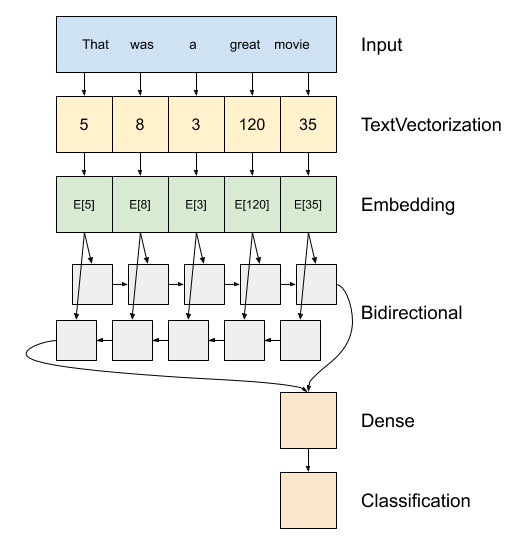

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2.many2many

본 예제는 https://wikidocs.net/24996 를 따랐습니다.

설명....할 시간이 없을 것 같네요

링크에 설명이 잘 나와있으니 만약에 시간이 남아서 이 부분도 수업시간에 다루게 되면 보면서 설명할게요!

In [149]:
import os
import shutil
import zipfile

import pandas as pd
import tensorflow as tf
import urllib3
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [150]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)
with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

In [155]:
lines = pd.read_csv('fra.txt', names=['src', 'tar', 'lic'], sep='\t')
del lines['lic']
print('전체 샘플의 개수 :',len(lines))

전체 샘플의 개수 : 197463


In [156]:
lines = lines.loc[:, 'src':'tar']
lines = lines[0:60000] # 6만개만 저장
lines.sample(10)

,src,tar
43001,I sometimes watch TV.,Je regarde parfois la télévision.
55784,He has gone to Britain.,Il est parti en Grande-Bretagne.
24728,I'm aware of that.,J'en suis consciente.
46894,Who is he talking to?,À qui parle-t-il ?
34100,You're out of luck.,Ta chance est épuisée.
29275,He's already a man.,C'est déjà un homme.
22010,Who's my teacher?,Qui est ma professeure ?
25066,It was a bad idea.,Ce fut une mauvaise idée.
14403,I often do that.,Je le fais beaucoup.
19953,Let's take a cab.,Prenons un taxi.


In [157]:
lines.tar = lines.tar.apply(lambda x : '\t '+ x + ' \n')
lines.sample(10)

,src,tar
14680,I'll never tell.,\t Je ne le dirai jamais. \n
21807,What do you like?,\t Qu'apprécies-tu ? \n
8754,Tie your shoe.,\t Noue ta chaussure. \n
20927,This stopped Tom.,\t Ceci a arrêté Tom. \n
14261,I like your dog.,\t J'aime ton chien. \n
15371,May I try it on?,\t Puis-je l'essayer ? \n
44871,Something is missing.,\t Quelque chose manque. \n
1938,I do worry.,\t Je me fais vraiment du souci. \n
18017,Have you decided?,\t T'es-tu décidé ? \n
46367,We shouldn't do this.,\t Nous ne devrions pas faire ceci. \n


In [158]:
# 문자 집합 구축
src_vocab = set()
for line in lines.src: # 1줄씩 읽음
    for char in line: # 1개의 문자씩 읽음
        src_vocab.add(char)

tar_vocab = set()
for line in lines.tar:
    for char in line:
        tar_vocab.add(char)

In [159]:
src_vocab_size = len(src_vocab)+1
tar_vocab_size = len(tar_vocab)+1
print('source 문장의 char 집합 :',src_vocab_size)
print('target 문장의 char 집합 :',tar_vocab_size)

source 문장의 char 집합 : 79
target 문장의 char 집합 : 105


영어에 없는 프랑스어 list 에 index 주기

In [160]:
src_vocab = sorted(list(src_vocab))
tar_vocab = sorted(list(tar_vocab))
src_to_index = dict([(word, i+1) for i, word in enumerate(src_vocab)])
tar_to_index = dict([(word, i+1) for i, word in enumerate(tar_vocab)])

In [161]:
encoder_input = []

# 1개의 문장
for line in lines.src:
  encoded_line = []
  # 각 줄에서 1개의 char
  for char in line:
    # 각 char을 정수로 변환
    encoded_line.append(src_to_index[char])
  encoder_input.append(encoded_line)
print('source 문장의 정수 인코딩 :',encoder_input[:5])

source 문장의 정수 인코딩 : [[30, 64, 10], [30, 64, 10], [30, 64, 10], [30, 64, 10], [31, 58, 10]]


In [162]:
decoder_input = []
for line in lines.tar:
  encoded_line = []
  for char in line:
    encoded_line.append(tar_to_index[char])
  decoder_input.append(encoded_line)
print('target 문장의 정수 인코딩 :',decoder_input[:5])

target 문장의 정수 인코딩 : [[1, 3, 48, 53, 3, 4, 3, 2], [1, 3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [1, 3, 31, 66, 3, 70, 67, 73, 72, 57, 3, 4, 3, 2], [1, 3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [1, 3, 45, 53, 64, 73, 72, 3, 4, 3, 2]]


In [163]:
decoder_target = []
for line in lines.tar:
  timestep = 0
  encoded_line = []
  for char in line:
    if timestep > 0:
      encoded_line.append(tar_to_index[char])
    timestep = timestep + 1
  decoder_target.append(encoded_line)
print('target 문장 레이블의 정수 인코딩 :',decoder_target[:5])

target 문장 레이블의 정수 인코딩 : [[3, 48, 53, 3, 4, 3, 2], [3, 39, 53, 70, 55, 60, 57, 14, 3, 2], [3, 31, 66, 3, 70, 67, 73, 72, 57, 3, 4, 3, 2], [3, 28, 67, 73, 59, 57, 3, 4, 3, 2], [3, 45, 53, 64, 73, 72, 3, 4, 3, 2]]


In [164]:
max_src_len = max([len(line) for line in lines.src])
max_tar_len = max([len(line) for line in lines.tar])
print('source 문장의 최대 길이 :',max_src_len)
print('target 문장의 최대 길이 :',max_tar_len)

source 문장의 최대 길이 : 23
target 문장의 최대 길이 : 76


In [165]:
encoder_input = pad_sequences(encoder_input, maxlen=max_src_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_tar_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_tar_len, padding='post')
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

In [168]:
encoder_input.shape

(60000, 23, 79)

In [15]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
import numpy as np

encoder_inputs = Input(shape=(None, src_vocab_size))
encoder_lstm = LSTM(units=256, return_state=True)

# encoder_outputs은 여기서는 불필요
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# LSTM은 바닐라 RNN과는 달리 상태가 두 개. 은닉 상태와 셀 상태.
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None, tar_vocab_size))
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# 디코더에게 인코더의 은닉 상태, 셀 상태를 전달.
decoder_outputs, _, _= decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_softmax_layer = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 79)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 105)]  0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        344064      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

In [ ]:
# model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=40, validation_split=0.2)

model.fit(x=[encoder_input, decoder_input], y=decoder_target, batch_size=64, epochs=1, validation_split=0.1)

Epoch 1/40
750/750 [==============================] - 430s 568ms/step - loss: 0.7362 - val_loss: 0.6710
Epoch 2/40
750/750 [==============================] - 457s 610ms/step - loss: 0.4573 - val_loss: 0.5367
Epoch 3/40
750/750 [==============================] - 465s 620ms/step - loss: 0.3816 - val_loss: 0.4733
Epoch 4/40
218/750 [=======>......................] - ETA: 5:17 - loss: 0.3489